# Проект:  **"Металлургия"**

# План:
 1. Введение
 2. Выгрузка данных
 3. Исследовательский анализ данных по всем таблицам
 4. Обработка данных, фичь-инженеринг и группировка
 5. Объединение в одну таблицу и анализ общей таблицы
 6. Разбиение на 2 выборки (учебная 75%)
 7. Кодирование признаков, если выбранная модель требует этот пункт
 8. Обучение константной модели (среднее, медиана, начальная температура)
 8. Обучение моделей с использованием кросс-валидаций, сравнение с константной
 9. Выбор лучшей модели, выявление важности признаков
 10. Проверка лучшей модели на тестовой выборке
 11. Вывод
 12. Отчет о проделанной работе

## Введение
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали в одном ковше и выстроет прогноз для последнего измерения для каждой партии.

Умение спрогнозировать температуру поможет компании снизить энерго-затратны обслуживание и ремонт оборудования.

**Цель:**
Построить модель машинного обучения, которая на основании первого замера температуры выстроит прогноз для последнего замера. Добится точности MAE < 6.8

### Технологический процесс
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Во всех файлах столбец `key` содержит номер партии.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install -q catboost tqdm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

from catboost import CatBoostRegressor

RANDOM_STATE = 250923
CV=3

# **I часть**

# Загрузка данных

In [ ]:
try:
    ark = pd.read_csv("C:\\Users\\Sergo\\Desktop\\data\\data_arc_new.csv")              #электроды
    bulk_new = pd.read_csv('C:\\Users\\Sergo\\Desktop\\data\\data_bulk_new.csv')        #подача сыпучих материалов (объём)
    bulk_time = pd.read_csv('C:\\Users\\Sergo\\Desktop\\data\\data_bulk_time_new.csv')  #подача сыпучих материалов (время)
    gas = pd.read_csv('C:\\Users\\Sergo\\Desktop\\data\\data_gas_new.csv')              #продувка сплава газом
    tamp = pd.read_csv('C:\\Users\\Sergo\\Desktop\\data\\data_temp_new.csv')            #результаты измерения температуры
    wire = pd.read_csv('C:\\Users\\Sergo\\Desktop\\data\\data_wire_new.csv')            #проволочные материалы (объём)
    wire_time = pd.read_csv('C:\\Users\\Sergo\\Desktop\\data\\data_wire_time_new.csv')  #проволочные материалы (время)
except:
    ark = pd.read_csv('/datasets/data_arc_new.csv')
    bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    gas = pd.read_csv('/datasets/data_gas_new.csv')
    tamp = pd.read_csv('/datasets/data_temp_new.csv')
    wire = pd.read_csv('/datasets/data_wire_new.csv')
    wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

# Исследовательский анализ данныз - exploratory data analysis (EDA)

In [ ]:
#ф-ция для первичного анализа
def EDA(df):
    print('Размерность таблицы:',df.shape, ', (кол-во строк, столбцов)')
    print('')
    (df.info())
    print('')
    display(df.head())
    print('Проверка на наличие пропусков:')
    display(df.isnull().sum())
    display(df.describe())
    print('')
    print('Количество дублирующих строк:', df.duplicated().sum())
    return


## EDA Электродов

In [ ]:
EDA(ark)

Размерность таблицы: (14876, 5) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Проверка на наличие пропусков:


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Количество дублирующих строк: 0


In [ ]:
print('Всего партий:', ark['key'].unique().max())
print('Количество включений электродов для каждой партии:', round(ark.shape[0] / len(ark['key'].unique()), 2))

Всего партий: 3241
Количество включений электродов для каждой партии: 4.63


In [ ]:
print('Начало  работы электрода:')
display(ark[['Начало нагрева дугой']].head(1))
print('')
print('Завершение работы электрода:')
display(ark[['Конец нагрева дугой']].tail(1))

Начало  работы электрода:


,Начало нагрева дугой
0,2019-05-03 11:02:14



Завершение работы электрода:


,Конец нагрева дугой
14875,2019-09-06 17:26:15


In [ ]:
#группировка данные для каждого процесса
ark_group = ark.groupby(by='key').agg('sum').reset_index(drop=True)

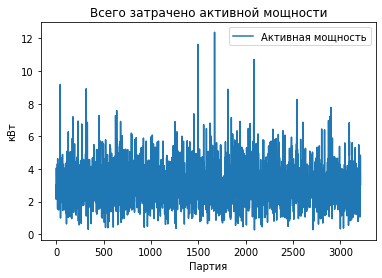

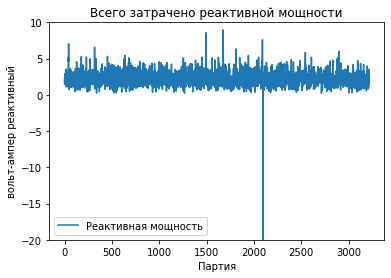

In [ ]:
sns.lineplot(data=ark_group[['Активная мощность']])
#заголовки
plt.title('Всего затрачено активной мощности')
plt.ylabel('кВт')
plt.xlabel('Партия')
plt.show()

sns.lineplot(data=ark_group[['Реактивная мощность']])
plt.ylim(-20, 10)
#заголовки
plt.title('Всего затрачено реактивной мощности')
plt.ylabel('вольт-ампер реактивный')
plt.xlabel('Партия')
plt.show()


In [ ]:
#удалим партию с явным выбросом везде
display(ark[ark['Реактивная мощность']< 0])

ark = ark[ark['key'] != 2116]
bulk_new = bulk_new[bulk_new['key'] != 2116]
bulk_time = bulk_time[bulk_time['key'] != 2116]
gas = gas[gas['key'] != 2116]
tamp = tamp[tamp['key'] != 2116]
wire = wire[wire['key'] != 2116]
wire_time = wire_time[wire_time['key'] != 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


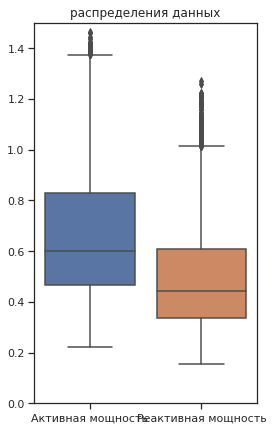

In [ ]:
plt.figure(figsize=(4, 7))
#1 график
sns.set(style="ticks")
sns.boxplot(data=ark[['Активная мощность', 'Реактивная мощность']])
plt.ylim(0, 1.5)
#заголовки
plt.title('распределения данных')
plt.show()

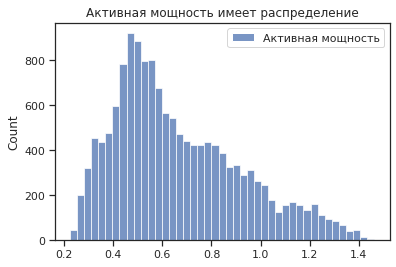

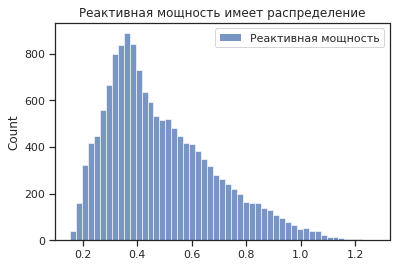

In [ ]:
#1 график
sns.set(style="ticks")
sns.histplot(data=ark[['Активная мощность']])
#plt.ylim(-0.5, 1.5)
#заголовки
plt.title('Активная мощность имеет распределение')
plt.show()

#2 график
sns.set(style="ticks")
sns.histplot(data=ark[['Реактивная мощность']])
#plt.ylim(-0.5, 1.5)
#заголовки
plt.title('Реактивная мощность имеет распределение')
plt.show()

Гистограммы имеют весьма схожий вид, необходимо проверить наличие корреляции между этими признаками.

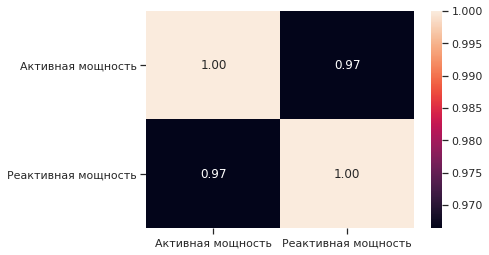

In [ ]:
corr_akt_reakt = ark[['Активная мощность', 'Реактивная мощность']].corr()

sns.heatmap(corr_akt_reakt, annot=True,  fmt=".2f");

**Вывод для таблицы `ark`:**
- Таблице отсутствуют пропуски и дубликаты.
- Столбец -  `Начало нагрева дугой` и `Конец нагрева дугой` в будущем необходимо перевести в формат даты, временная последовательность не нарушена. (если такой признак нам будет необходим при дальнейшем исследовании).
- Отрицательное значение в столбце `Реактивная мощность` похоже на выброс. Ссылаясь на документацию, реактивная мощность может быть отрицательной, но в нашем случае это выглядит как скачет который в разы больше, чем все остальные показатели. __Данная партия удалена.__
- Столбец `Активная мощность` имеет небольшое количество выбросов, но они не так сильно искажают данные, поэтому их можно оставить без изменения.
- Исследование на корреляционную зависимость выявило прямую зависимость признаков. Такие признаки могут привести к проблеме мультиколлинеарности и снизить качество моделей, поэтому необходимо оставить только 1 признак.
- Возможно добавить признака `Полная мощность`:

  $$S = U \cdot I$$  $$или$$   $$Полная мощность =
\sqrt{Активная\ мощность^2 + Реактивная\ мощность^2}$$




## EDA Сыпучие материалы - Объем

In [ ]:
EDA(bulk_new)

Размерность таблицы: (3128, 16) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   575 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2805 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Проверка на наличие пропусков:


key           0
Bulk 1     2876
Bulk 2     3106
Bulk 3     1830
Bulk 4     2114
Bulk 5     3051
Bulk 6     2553
Bulk 7     3103
Bulk 8     3127
Bulk 9     3109
Bulk 10    2952
Bulk 11    2951
Bulk 12     678
Bulk 13    3110
Bulk 14     323
Bulk 15     880
dtype: int64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3128.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,575.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2805.000000,2248.000000
mean,1624.226343,39.242063,253.045455,113.879045,104.394477,107.025974,118.893913,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.274866,160.513345
std,933.445456,18.277654,21.180578,75.483494,48.184126,81.790646,72.116564,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.878317,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,815.750000,27.000000,242.000000,58.000000,72.000000,70.000000,69.500000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1621.500000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.250000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,206.000000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Количество дублирующих строк: 0


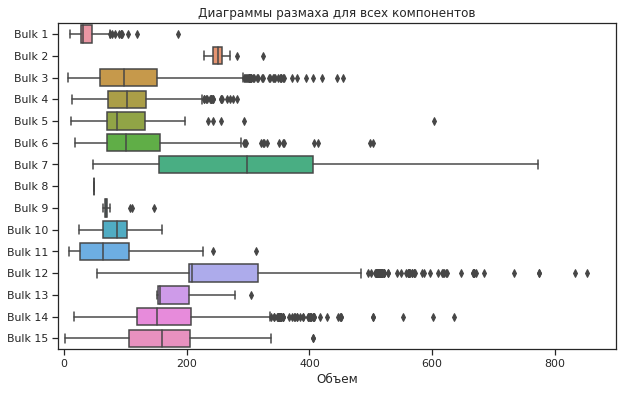

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=bulk_new.drop('key', axis=1), orient='h')
#заголовки
plt.title('Диаграммы размаха для всех компонентов')
plt.xlim(-10, 900)
plt.xlabel('Объем')
plt.show()

Компонент 12 добавили для одной партии больше 1750 единиц. Видимо был экстраординарный случай, который потребовал экстренного вмешательства.

**Вывод к таблице `bulk_new:**
- Таблица содержит информацию о добавлении сыпучих веществах для каждой партии, все столбцы имеют численный формат.
- В каждом столбце присутствуют пропуски в большом количестве все, потому что сыпучая добавка не добавлялась. Пропуски можно заполнить нулями.
- Можно предположить, что под шифром bulk (1-15) подразумевается добавление определенного вещества к определенной партии. В основном добавляют сыпуче компоненты Bulk: 12, 14, 15. Все остальные добавки являются второстепенными и не обязательными.
- График отобразил, что объем определяемого вещества находится +- в одном диапазоне и не меняется от партии к партии. Но выбросы имеются у каждого сыпучего компонента.
- При выборе признаков стоит убрать те сыпучие компоненты, которые вносили меньше всего.


## EDA Сыпуче метериалы - Время

In [ ]:
EDA(bulk_time)

Размерность таблицы: (3128, 16) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3128 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   575 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2805 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 415.4+ KB



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Проверка на наличие пропусков:


key           0
Bulk 1     2876
Bulk 2     3106
Bulk 3     1830
Bulk 4     2114
Bulk 5     3051
Bulk 6     2553
Bulk 7     3103
Bulk 8     3127
Bulk 9     3109
Bulk 10    2952
Bulk 11    2951
Bulk 12     678
Bulk 13    3110
Bulk 14     323
Bulk 15     880
dtype: int64

,key
count,3128.000000
mean,1624.226343
std,933.445456
min,1.000000
25%,815.750000
50%,1621.500000
75%,2431.250000
max,3241.000000



Количество дублирующих строк: 0


**Вывод к таблице `bulk_time`:**
- Данная таблица является дополнением таблицы `bulk_new` и содержит информацию о дате и времени добавлении присадки.
- Если в дальнейшем как-то придется использовать и объединять таблицы дату нужно будет перевести из текстового формата в формат даты. Но целесообразность извлечения временных признаков и применения их в будущем для обучения моделей, я не вижу.  


## EDA Продувка сплава газом.
Такой этап обработки стали позволяет снизить уровень содержания в ней не относящихся к металлам добавок, в том числе кислорода и серы.

In [ ]:
EDA(gas)

Размерность таблицы: (3238, 2) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3238 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3238 non-null   int64  
 1   Газ 1   3238 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.9 KB



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Проверка на наличие пропусков:


key      0
Газ 1    0
dtype: int64

,key,Газ 1
count,3238.000000,3238.000000
mean,1621.708771,11.001883
std,935.490478,6.221280
min,1.000000,0.008399
25%,812.250000,7.042678
50%,1621.500000,9.832531
75%,2431.750000,13.770937
max,3241.000000,77.995040



Количество дублирующих строк: 0


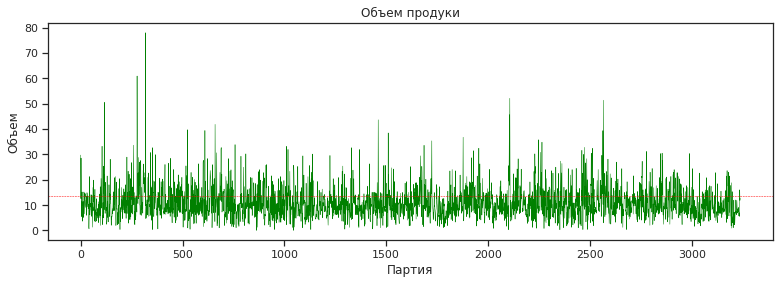

In [ ]:
plt.figure(figsize=(13,4))
sns.lineplot(data=gas['Газ 1'], color='green', linewidth=0.5)

# Добавление линии для 75-процентного квантиля
quantile_75 = int(len(gas['Газ 1']) * 0.75)
y_sorted = sorted(gas['Газ 1'])
plt.axhline(y_sorted[quantile_75], color='red', linestyle='--',
            label='75% квантиль', linewidth=0.5)

#заголовки
plt.title('Объем продуки')
plt.ylabel('Объем')
plt.xlabel('Партия')
plt.show()

Добавил линию 75-процентного квантиля на график чтобы посмотреть, как данные распределены и что может возможно является выбросами.

**Вывод к таблице `gas`:**
- Каждую партию продувают определенным количеством газа, в течение процесса плавления. Одна из функции этого процесса является перемешивание содержимого. Объем подаваемой смеси зависит от технологических показателей сырья.
- В некоторых случаях процесс продувки практически отсутствует, в то время как в других партиях наблюдается избыточность данного процесса. По Т.З. заказчика такие данные в таблице не являются выбросами, а необходимыми мерами для переработки – оставляем.

## EDA Результатов измерения температуры
*Стоит начать этот раздел важной заметки*
* Температура плавления стали в диапазоне : 1450—1520 °C

In [ ]:
EDA(tamp)

Размерность таблицы: (18087, 3) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18087 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18087 non-null  int64  
 1   Время замера  18087 non-null  object 
 2   Температура   14660 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 565.2+ KB



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Проверка на наличие пропусков:


key                0
Время замера       0
Температура     3427
dtype: int64

,key,Температура
count,18087.000000,14660.000000
mean,1616.322884,1590.727490
std,934.733659,20.396206
min,1.000000,1191.000000
25%,807.000000,1580.000000
50%,1617.000000,1590.000000
75%,2429.500000,1599.000000
max,3241.000000,1705.000000



Количество дублирующих строк: 0


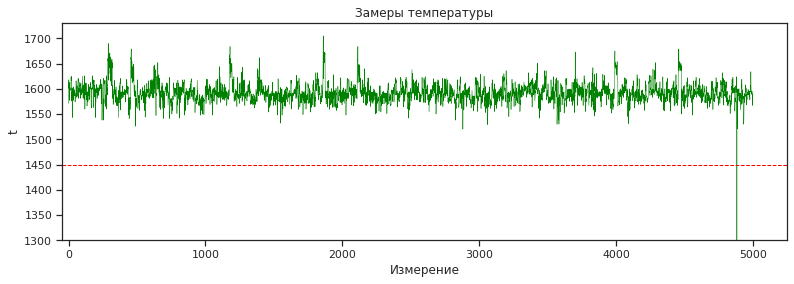

In [ ]:
#выбираю первые 5000 записей t
tapm_tabl = tamp['Температура'].loc[0:5000]

plt.figure(figsize=(13,4))
sns.lineplot(data=tapm_tabl, color='green', linewidth=0.5)
plt.ylim(1300, None)

#Температура плавления стали
plt.axhline(1450, color='red', linestyle='--',label='t плавления', linewidth=1)
plt.xlim(-50, None)

#заголовки
plt.title('Замеры температуры')
plt.ylabel('t')
plt.xlabel('Измерение')
plt.show()

**Вывод к таблице `tapm`:**
- Столбец `Температура` является целевым, который попросил спрогнозировать заказчик.
- Данный признак имеет большое количество пропусков, поэтому при удалении одной 1-го пропуска измерения в партии удаляются все остальные. Так же нес не будут интересовать те измерения, где проходил 1 замер температуры.
- По уточнению заказчика, если температура плавления указана ниже пороговой, то это сбой системы и такие данные не нужно учитывать – удаляем всю партию.
- Так же в данной таблице можно создать признак, общее время нагрева для каждой партии.

## EDA Проволочные материалы - Объём

In [ ]:
EDA(wire)

Размерность таблицы: (3080, 10) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3080 non-null   int64  
 1   Wire 1  3054 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 264.7 KB



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверка на наличие пропусков:


key          0
Wire 1      26
Wire 2    2001
Wire 3    3017
Wire 4    3066
Wire 5    3079
Wire 6    3007
Wire 7    3069
Wire 8    3061
Wire 9    3051
dtype: int64

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3080.000000,3054.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.266558,100.904261,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,933.105985,42.016827,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,822.750000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1618.500000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.250000,126.060485,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Количество дублирующих строк: 0


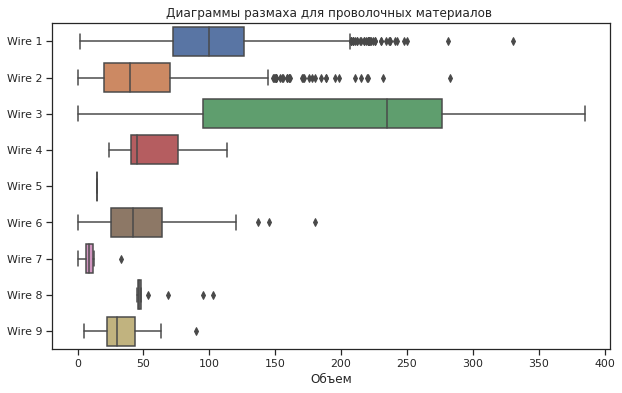

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=wire.drop('key', axis=1), orient='h')
#заголовки
plt.title('Диаграммы размаха для проволочных материалов ')
plt.xlabel('Объем')
plt.show()

Добавление `Wire 3 ` происходит редко, но в большом объеме, поэтому я оставил этот признак.

**Вывод к таблице `wire`:**
- Принцип таблиц очень схож с таблицей с внесением сухих веществ. Поэтому все пропуски возможно заполнять 0.
- Чаще всего добавляют Wire 1, практически в каждой партии. Для будущего отбора признаков стоит оставить только Wire 1-2-3.
- Для некоторых проволочных материалов даже не вышло построить «нормальную» диаграмму размаха по причине отсутствия данных.

## EDA Проволочные материалы - Вемя

In [ ]:
EDA(wire_time)

Размерность таблицы: (3080, 10) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3080 non-null   int64 
 1   Wire 1  3054 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 264.7+ KB



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверка на наличие пропусков:


key          0
Wire 1      26
Wire 2    2001
Wire 3    3017
Wire 4    3066
Wire 5    3079
Wire 6    3007
Wire 7    3069
Wire 8    3061
Wire 9    3051
dtype: int64

,key
count,3080.000000
mean,1623.266558
std,933.105985
min,1.000000
25%,822.750000
50%,1618.500000
75%,2434.250000
max,3241.000000



Количество дублирующих строк: 0


**Вывод к таблице `wire_time`:**
- Время добавления проволочного материала не играет для нас важной роли, поэтому в дальнейшем она больше не будет рассматривается. Данная таблица позволила убедится в том, что проволочный компонент действительно добавили в нужную партию и не более.

# **Вывод к блоку EDA:**
- В данном разделе мы только визуально ознакомились с данными и сделал выводы о том какие партии можно удалить, рассмотрели выбросы. В следующем разделе предстоит провести полную предобработку данных и объединить в одну общую таблицу.
- Таблицы с временем внесения сыпучих компонентов и проволочных компонентов в общую таблицу не войдут.
- Время измерения температуры и другие показатели, связанные с временем, не войдут в исследование. Но необходимо будет рассчитать время, за которое ковш нагрелся до необходимой температуры и получить новый признак.
- В таблицах присутствуют выбросы по причине технических сбоев приборов измерения. Такие данные необходимо удалить из таблиц. Другие выбросы связанны с технологическим процессом, поэтому их необходимо оставить.
- Следующем шагом необходимо сгруппировать партии и оставить только первый и последний замер температуры. На основании всех отобранных фичей + первичного замера температуры, нужно сделать предсказание конечной температуры.


****



# **II часть**

# Предобработка выбранных таблиц
  
  ark, bulk_new, gas, tamp, wire

In [ ]:
#ф-ция удаления определенных партий из всех таблиц
def drop_part(part, ark, bulk_new, gas, tamp, wire):

  print('Количество строк `ark` до удаления партий -', ark.shape[0])
  ark = ark[~ark['key'].isin(part)]
  print('После удаления партии', ark.shape[0])

  print('Количество строк `bulk_new` до удаления партий -', bulk_new.shape[0])
  bulk_new = bulk_new[~bulk_new['key'].isin(part)]
  print('После удаления партии', bulk_new.shape[0])

  print('Количество строк `gas` до удаления партий -', gas.shape[0])
  gas = gas[~gas['key'].isin(part)]
  print('После удаления партии', gas.shape[0])

  print('Количество строк `tamp` до удаления партий -', tamp.shape[0])
  tamp = tamp[~tamp['key'].isin(part)]
  print('После удаления партии', tamp.shape[0])

  print('Количество строк `wire` до удаления партий -', wire.shape[0])
  wire = wire[~wire['key'].isin(part)]
  print('После удаления партии', wire.shape[0])

  return ark, bulk_new, gas, tamp, wire

In [ ]:
#x = [11, 12, 13]

#ark, bulk_new, gas, tamp, wire = drop_part(x, ark, bulk_new, gas, tamp, wire)

## Обработка таблицы с электродами
 - Создание нового признака __Полная мощность__
 - Удаление других корелирующих признаков
 - Удаление столбцов с датой
 - Группировка замеров

In [ ]:
ark['Полная мощность'] = (ark['Активная мощность']**2 + ark['Реактивная мощность']**2)**0.5
ark.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


Еще раз проверим признаки на наличия корреляции и сделаем выбор

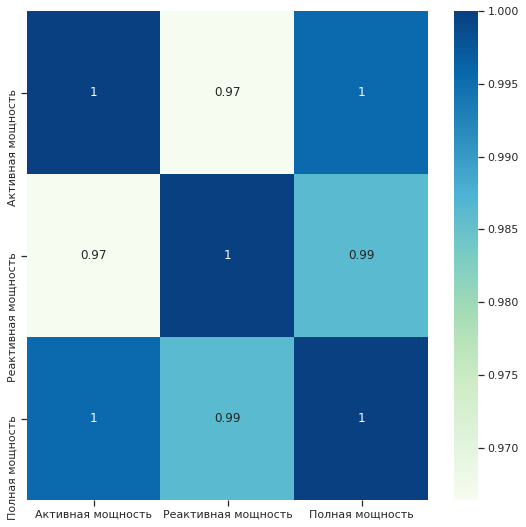

In [ ]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

ark_corre = ark[['Активная мощность', 'Реактивная мощность', 'Полная мощность']].corr()

sns.set(style='ticks', color_codes=True)
sns.heatmap(ax=ax, data=ark_corre,annot=True, cmap='GnBu')

plt.show()
plt.close()

Удаляем старые признака + дату и оставляем новый, и номер партии

In [ ]:
ark = ark[['key', 'Полная мощность']]

**Группировка таблицы**
`ark`

В таблице `ark` из нескольких замеров варки необходимо оставить только один - сумму.

In [ ]:
ark = ark.groupby('key').agg(['sum']).reset_index()

In [ ]:
ark.columns = ['key', 'Полная_мощность_сумма']

In [ ]:
ark.shape

(3213, 2)

In [ ]:
ark.info()
ark.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    3213 non-null   int64  
 1   Полная_мощность_сумма  3213 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


,key,Полная_мощность_сумма
0,1,3.718736
1,2,2.588349
2,3,5.019223
3,4,3.400038
4,5,2.816980


## Обработка таблицы c cыпучие материалы - Объем
- Удалил те компоненты которые практически не добавлялись, вдальнейшем после постраения модели признаки будут не актуальными их можно будет отбросить.
- Заполняю пропуски 0.

In [ ]:
bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   575 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2805 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB


In [ ]:
#bulk_dell = ['Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']

#bulk_new = bulk_new.drop(bulk_dell, axis=1)

In [ ]:
bulk_new.fillna(0, inplace=True)

In [ ]:
bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   Bulk 1   3128 non-null   float64
 2   Bulk 2   3128 non-null   float64
 3   Bulk 3   3128 non-null   float64
 4   Bulk 4   3128 non-null   float64
 5   Bulk 5   3128 non-null   float64
 6   Bulk 6   3128 non-null   float64
 7   Bulk 7   3128 non-null   float64
 8   Bulk 8   3128 non-null   float64
 9   Bulk 9   3128 non-null   float64
 10  Bulk 10  3128 non-null   float64
 11  Bulk 11  3128 non-null   float64
 12  Bulk 12  3128 non-null   float64
 13  Bulk 13  3128 non-null   float64
 14  Bulk 14  3128 non-null   float64
 15  Bulk 15  3128 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB


In [ ]:
bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## Обработка таблицы с измерениями температуры
- Удаление партий с пропусками температуры.
- Удаление партий, в которых произошел сбой замера температуры.
- Удаление партий с 1 измерением температуры.
- Добавление признака `Общее время плавления`.
- Удаление даты.


In [ ]:
tamp_null_key = list(tamp[tamp['Температура'].isna()]['key'])

ark, bulk_new, gas, tamp, wire = drop_part(tamp_null_key, ark, bulk_new, gas, tamp, wire)

Количество строк `ark` до удаления партий - 3213
После удаления партии 2474
Количество строк `bulk_new` до удаления партий - 3128
После удаления партии 2407
Количество строк `gas` до удаления партий - 3238
После удаления партии 2499
Количество строк `tamp` до удаления партий - 18087
После удаления партии 13921
Количество строк `wire` до удаления партий - 3080
После удаления партии 2372


Данные партии было необходимо удалить из всех таблиц, т.к. данный признак является целевым и пытаться его как-то заполнять это некорректно.

Откинули 4 166 строк и пропусков не стало!

**Удаление партий в которых замер температуры был ниже 1450°**

In [ ]:
tamp_drop = list(tamp[tamp['Температура'] < 1450]['key'])
print('Партии, в которых плавление стали было ниже порога:', tamp_drop)
print('')
ark, bulk_new, gas, tamp, wire = drop_part(tamp_drop, ark, bulk_new, gas, tamp, wire)

Партии, в которых плавление стали было ниже порога: [867, 1214, 1619, 2052]

Количество строк `ark` до удаления партий - 2474
После удаления партии 2470
Количество строк `bulk_new` до удаления партий - 2407
После удаления партии 2403
Количество строк `gas` до удаления партий - 2499
После удаления партии 2495
Количество строк `tamp` до удаления партий - 13921
После удаления партии 13900
Количество строк `wire` до удаления партий - 2372
После удаления партии 2368


**Для исследования не подойдут партии с 1 замером, для такой партии будет нечего предсказывать:**

In [ ]:
#Дефектные партии
group_tamp = tamp.groupby('key').count()[['Температура']].reset_index(drop=False)

group_tamp[group_tamp['Температура'] <= 1]

,key,Температура
192,195,1
276,279,1


In [ ]:
ark, bulk_new, gas, tamp, wire = drop_part([195, 279], ark, bulk_new, gas, tamp, wire)

Количество строк `ark` до удаления партий - 2470
После удаления партии 2470
Количество строк `bulk_new` до удаления партий - 2403
После удаления партии 2402
Количество строк `gas` до удаления партий - 2495
После удаления партии 2493
Количество строк `tamp` до удаления партий - 13900
После удаления партии 13898
Количество строк `wire` до удаления партий - 2368
После удаления партии 2367


Для расчета даты нужно изменить формат даты.

$$timesum = Последний - первый $$



In [ ]:
tamp['Время замера'] = pd.to_datetime(tamp['Время замера'])

In [ ]:
tamp = tamp.groupby('key').agg(['first', 'last']).reset_index()
tamp.columns = ['key','Начало', 'Конец',
                'Начальная температура', 'Конечная температура']

In [ ]:
tamp['time_all_min'] = (tamp['Конец'] - tamp['Начало']).astype('timedelta64[m]')
tamp = tamp.drop(['Начало', 'Конец'], axis=1)

In [ ]:
tamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2470 non-null   int64  
 1   Начальная температура  2470 non-null   float64
 2   Конечная температура   2470 non-null   float64
 3   time_all_min           2470 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 77.3 KB


In [ ]:
tamp.head()

,key,Начальная температура,Конечная температура,time_all_min
0,1,1571.0,1613.0,28.0
1,2,1581.0,1602.0,21.0
2,3,1596.0,1599.0,29.0
3,4,1601.0,1625.0,20.0
4,5,1576.0,1602.0,25.0


## Обработка таблицы с проволочными компонентами
- Удаление компонентов, которые практически не добавлялись.
- Заполнение пропусков 0.

In [ ]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2367 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2367 non-null   int64  
 1   Wire 1  2343 non-null   float64
 2   Wire 2  831 non-null    float64
 3   Wire 3  39 non-null     float64
 4   Wire 4  12 non-null     float64
 5   Wire 5  0 non-null      float64
 6   Wire 6  45 non-null     float64
 7   Wire 7  4 non-null      float64
 8   Wire 8  13 non-null     float64
 9   Wire 9  28 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 203.4 KB


In [ ]:
#wire_drop = ['Wire 4', 'Wire 5', 'Wire 7', 'Wire 8']
#wire = wire.drop(wire_drop, axis=1)

In [ ]:
wire.fillna(0, inplace=True)

In [ ]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2367 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2367 non-null   int64  
 1   Wire 1  2367 non-null   float64
 2   Wire 2  2367 non-null   float64
 3   Wire 3  2367 non-null   float64
 4   Wire 4  2367 non-null   float64
 5   Wire 5  2367 non-null   float64
 6   Wire 6  2367 non-null   float64
 7   Wire 7  2367 non-null   float64
 8   Wire 8  2367 non-null   float64
 9   Wire 9  2367 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 203.4 KB


In [ ]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Вывод всего раздела:**
В данной главе были удалены все аномалии, заполнены пропуски, удалены лишние признаки. Партии удалялись из всех таблиц, а не только из одной.


## **Обединение таблиц в 1**

Количество партий на каждом этапе отличается, поэтому при общединении таблиц необзодимо использовать метод `inner` чтобы остались только общие пересечения.

In [ ]:
print('ark', len(ark['key'].unique()))
print('tamp', len(tamp['key'].unique()))
print('bulk_new', len(bulk_new['key'].unique()))
print('gas', len(gas['key'].unique()))
print('wire', len(wire['key'].unique()))

ark 2470
tamp 2470
bulk_new 2402
gas 2493
wire 2367


In [ ]:
#общая таблица
df = (ark.merge(tamp, how='inner', on='key')
         .merge(bulk_new, how='inner', on='key')
         .merge(gas, how='inner', on='key')
         .merge(wire, how='inner', on='key') )

In [ ]:
EDA(df)

Размерность таблицы: (2324, 30) , (кол-во строк, столбцов)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   int64  
 1   Полная_мощность_сумма  2324 non-null   float64
 2   Начальная температура  2324 non-null   float64
 3   Конечная температура   2324 non-null   float64
 4   time_all_min           2324 non-null   float64
 5   Bulk 1                 2324 non-null   float64
 6   Bulk 2                 2324 non-null   float64
 7   Bulk 3                 2324 non-null   float64
 8   Bulk 4                 2324 non-null   float64
 9   Bulk 5                 2324 non-null   float64
 10  Bulk 6                 2324 non-null   float64
 11  Bulk 7                 2324 non-null   float64
 12  Bulk 8                 2324 non-null   float64
 13  Bulk 9                 2324 non-null   float64
 

,key,Полная_мощность_сумма,Начальная температура,Конечная температура,time_all_min,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,3.718736,1571.0,1613.0,28.0,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.588349,1581.0,1602.0,21.0,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5.019223,1596.0,1599.0,29.0,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.400038,1601.0,1625.0,20.0,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.816980,1576.0,1602.0,25.0,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Проверка на наличие пропусков:


key                      0
Полная_мощность_сумма    0
Начальная температура    0
Конечная температура     0
time_all_min             0
Bulk 1                   0
Bulk 2                   0
Bulk 3                   0
Bulk 4                   0
Bulk 5                   0
Bulk 6                   0
Bulk 7                   0
Bulk 8                   0
Bulk 9                   0
Bulk 10                  0
Bulk 11                  0
Bulk 12                  0
Bulk 13                  0
Bulk 14                  0
Bulk 15                  0
Газ 1                    0
Wire 1                   0
Wire 2                   0
Wire 3                   0
Wire 4                   0
Wire 5                   0
Wire 6                   0
Wire 7                   0
Wire 8                   0
Wire 9                   0
dtype: int64

,key,Полная_мощность_сумма,Начальная температура,Конечная температура,time_all_min,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,3.886143,1587.368761,1593.372633,38.221170,3.435026,1.425559,47.317126,37.347676,2.645869,...,11.378854,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795
std,715.027927,1.517584,23.627590,11.207457,23.097282,12.424463,19.102530,75.238050,58.677890,22.426054,...,6.397008,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248
min,1.000000,0.331897,1519.000000,1541.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,628.750000,2.846893,1571.000000,1587.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.282534,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1254.500000,3.770584,1587.000000,1593.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.100687,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1867.250000,4.769753,1603.000000,1598.000000,46.000000,0.000000,0.000000,80.000000,77.250000,0.000000,...,14.218487,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,15.288271,1660.000000,1653.000000,394.000000,185.000000,325.000000,454.000000,281.000000,603.000000,...,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600



Количество дублирующих строк: 0


In [ ]:
print('В итоге осталось партий -', len(df['key'].unique()))

В итоге осталось партий - 2324


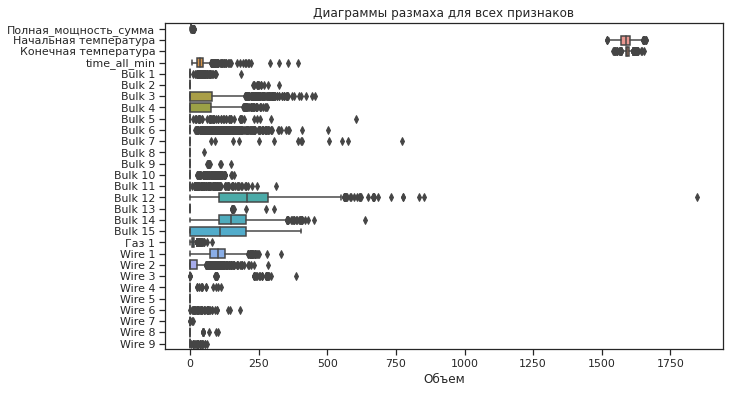

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df.drop('key', axis=1), orient='h')
#заголовки
plt.title('Диаграммы размаха для всех признаков')
plt.xlabel('Объем')
plt.show()

Как мы видим в признаках достаточно много выбросов и перекоса графиков – это связанно с тем, что большинство из них содержат большое количество 0 – эти нули возникают в результате непостоянства внесения компонентов, каждая партия требует свой уникальный подход. 

## **Проверка корреляции между признаками:**

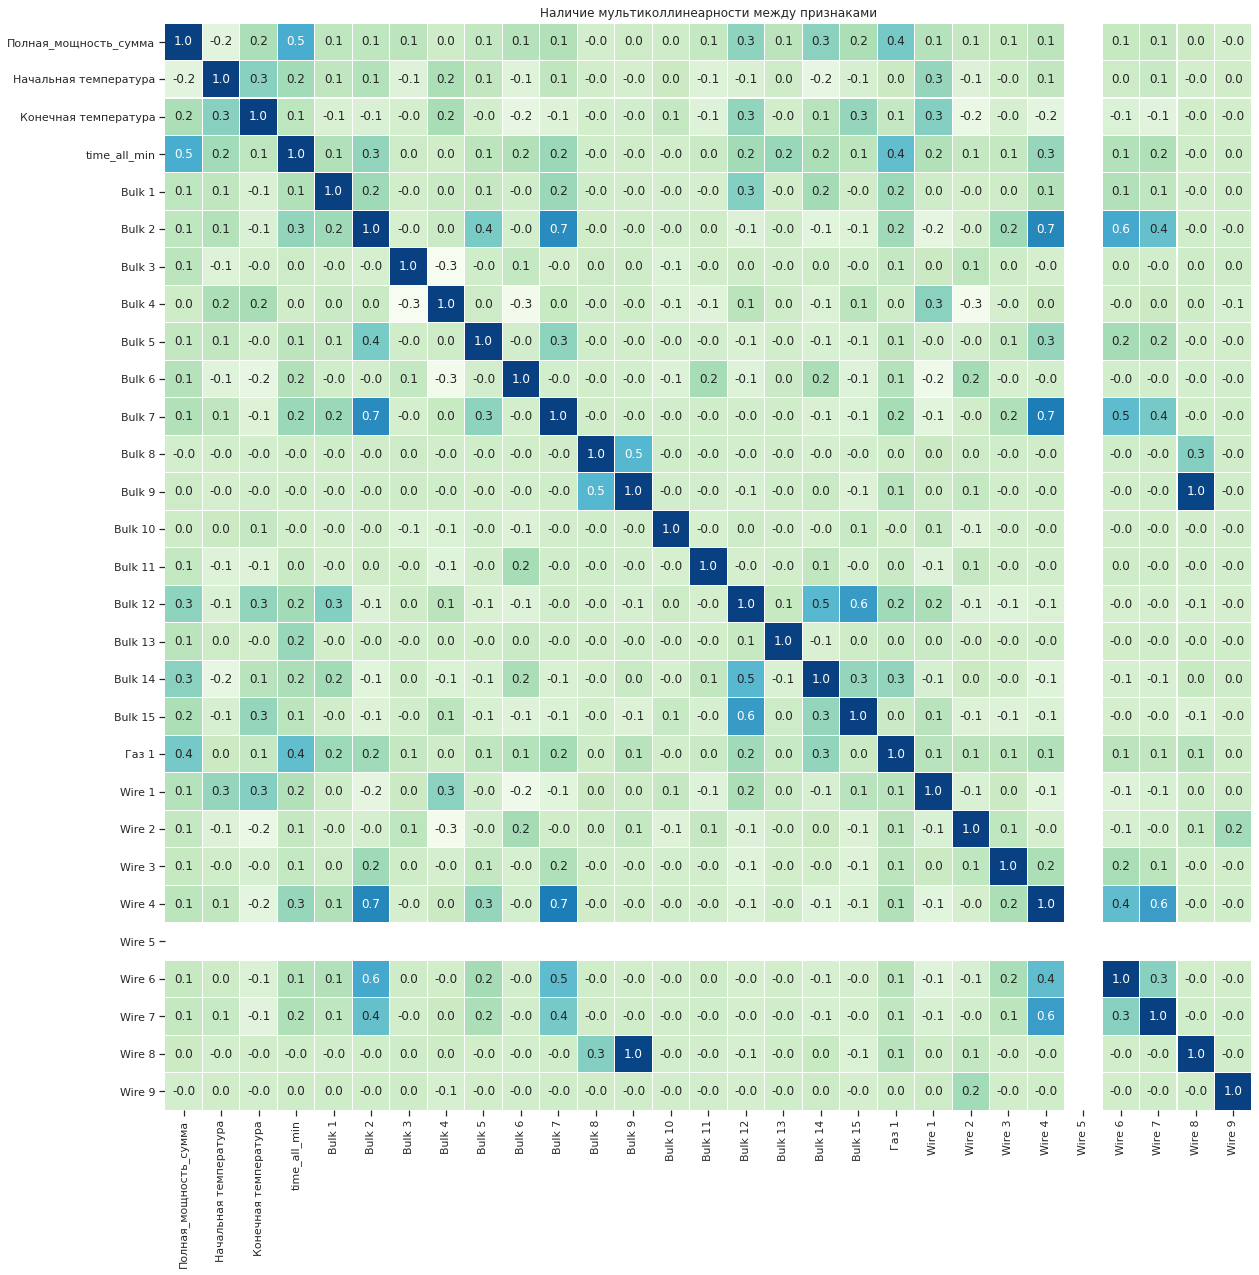

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

df_corr = df.drop('key', axis=1).corr()

sns.set(style='ticks', color_codes=True)
sns.heatmap(ax=ax, data=df_corr, annot=True, cmap='GnBu', fmt='.1f', 
            cbar=False, square=True, linewidth=0.1)
plt.title('Наличие мультиколлинеарности между признаками')

plt.show()
plt.close()

In [ ]:
df = df.drop(['Wire 5', 'Bulk 9'], axis=1)

Была выявлена сильная корреляция между признаками `Bulk 9` `Wire 8` (прямая зависимость), поэтому один признак был удален. `Wire 5` содержит мало измерений - признак удален. 

****
## $$**Machine ** Learning**$$
****

Я буду обучать 4 модели:
1. Базовую модель
2. RandomForestRegressor
3. ElasticNet - необходимо закодировать признаки и привести к одному диапазону
3. Бустинг – тут уже нет необходимости в кодировании признаков, поэтому буду использовать созданный датафрейм.

### Разбиение `df` на выборки
- Учебная выборка 75 %
- Тестовая 25 %

In [ ]:
train, test = train_test_split(df, test_size=.25, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
print('Размер тренировочной выборки:', train.shape[0])
print('Размер тестовой выборки:',test.shape[0])

Размер тренировочной выборки: 1743
Размер тестовой выборки: 581


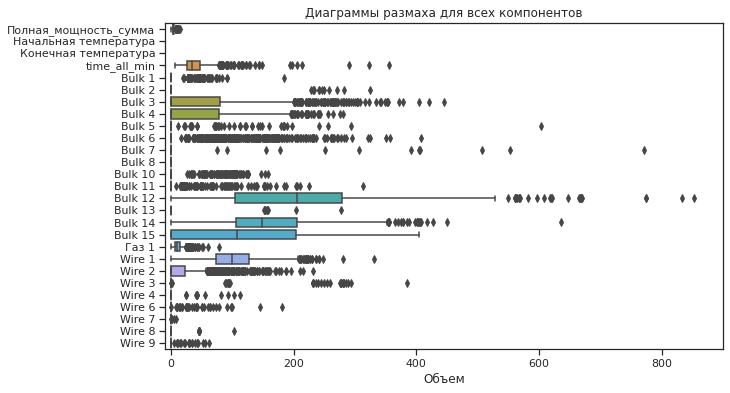

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=train.drop('key', axis=1), orient='h')
#заголовки
plt.title('Диаграммы размаха для всех компонентов')
plt.xlim(-10, 900)
plt.xlabel('Объем')
plt.show()

Обработаю выбросы в тренировочной выборке

In [ ]:
train = train[train['time_all_min']<8000]
train = train[train['Bulk 12']<600]

****
### Обучение базовой модели
****
Сравним начальную температуру с конечной — это будет наш бэйзлайн

Используем метрику оценки Абсолютное Cреднее Pначение(MAE) определяет различий между фактическими и предсказанными значениями, измеряется в градусах.

In [ ]:
basis_model = mae(train['Начальная температура'], train['Конечная температура'])

print(f'Mean Absolute Error для базовой модели: {round(basis_model, 1)}')

Mean Absolute Error для базовой модели: 19.1


****
### Обучение RandomForestRegressor

In [ ]:
x_col = df.drop(['key', 'Конечная температура'], axis=1).columns
y_col = df[['Конечная температура']].columns

In [ ]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
scorer = make_scorer(mae, greater_is_better=False)

parametrs = {'n_estimators': [50, 100, 125],
             'max_depth': [5, 8, 10, 15]}

grid_rfr = GridSearchCV(model, parametrs, verbose=0, scoring=scorer, cv=CV)
grid_rfr.fit(train[x_col], train['Конечная температура'])

#предсказание
#rfr_predict_train = grid_rfr.best_estimator_.predict(train[x_col])

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=250923),
             param_grid={'max_depth': [5, 8, 10, 15],
                         'n_estimators': [50, 100, 125]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [ ]:
rfr_predict_train_mae = abs(round(grid_rfr.best_score_, 2))

Мы создаем скорер с флагом  greater_is_better=False, поэтому score и отрицательный. Что-бы поиск по сетке всегда выбирал модель с самым большой метрикой.

In [ ]:
print('Mean Absolute Error для случайного леса:', rfr_predict_train_mae)
print('Параметры модели', grid_rfr.best_params_)

Mean Absolute Error для случайного леса: 7.09
Параметры модели {'max_depth': 10, 'n_estimators': 125}


**Вывод:** Отрицательное значение MAE говорит о том Гридсерчь стараеться, максимизировать метрику и имеет отрицательное MAE, что эквивалентно минимизации обычного MAE. Модель сделала прогнозы, которые очень близки к фактическим значениям.

****
#### Кодирование признаков
****



In [ ]:
#устранение конфликта sklearn и pandas
#pd.options.mode.chained_assignment = None

#1
scaler_1 = StandardScaler()
scaler_1.fit(train[x_col])

data_tr_stand = scaler_1.transform(train[x_col])
data_test_stand = scaler_1.transform(test[x_col])

In [ ]:
#проверка преобразованных признаков
data_tr_stand.shape, data_test_stand.shape

((1728, 26), (581, 26))

### Обучение ElasticNet
Это комбинация Ridge и Lasso регрессий. Она включает как L2-, так и L1-регуляризацию, позволяя балансировать их влияние с помощью гиперпараметра.

In [ ]:
model = ElasticNet(random_state=RANDOM_STATE)

param_grid = {
    'alpha': [0.1, 0.3, 0.5, 0.6],
    'l1_ratio': [0.1, 0.3, 0.5, 0.9]
    }

grid_elast = GridSearchCV(model, param_grid, scoring=scorer,
                         cv=CV, verbose=0,
                         )

grid_elast.fit(data_tr_stand, train['Конечная температура'])

GridSearchCV(cv=3, estimator=ElasticNet(random_state=250923),
             param_grid={'alpha': [0.1, 0.3, 0.5, 0.6],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.9]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [ ]:
elast_predict_train_mae = abs(round(grid_elast.best_score_, 2))

In [ ]:
print('Лучшие параметры модели', grid_elast.best_params_)
print('Mean Absolute Error для Elastic Net:', elast_predict_train_mae)

Лучшие параметры модели {'alpha': 0.3, 'l1_ratio': 0.5}
Mean Absolute Error для Elastic Net: 7.13


### Обучение модели CatBoostRegressor 


In [ ]:
par = {'iterations':1000,
       'learning_rate':0.013,
       'random_state':RANDOM_STATE,
       'boosting_type':'Ordered'}

model_cat = CatBoostRegressor(**par)

model_cat.fit(train[x_col], train[y_col], verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
model_cat = CatBoostRegressor(random_state=RANDOM_STATE)
#model_cat.fit(x_train, y_train)
param_grid = {
    'iterations': [1000],
    'learning_rate': [0.013],
    'depth': [4, 6],
    'l2_leaf_reg': [0.5, 0.9, 1.3],
    'border_count': [32, 64]}
              #'iterations': [100]

grid_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid,
                        cv=CV, scoring=scorer)

grid_cat.fit(train[x_col], train[y_col], verbose=False)
#pred_train_cat = grid_cat.predict(train[x_col])

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f2cc4d4a880>,
             param_grid={'border_count': [32, 64], 'depth': [4, 6],
                         'iterations': [1000], 'l2_leaf_reg': [0.5, 0.9, 1.3],
                         'learning_rate': [0.013]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [ ]:
pred_train_cat_mae = abs(round(grid_cat.best_score_, 2))

In [ ]:
print('Mean Absolute Error для СatBoost:', pred_train_cat_mae)
print('Параметры модели', grid_cat.best_params_)

Mean Absolute Error для СatBoost: {'border_count': 64, 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1.3, 'learning_rate': 0.013}
Параметры модели 6.9


## Определение лучшей модели
Объединим данные в таблицу и проанализируем результат чтобы можно выбрать лучшую модель.

In [ ]:
mod_all = pd.DataFrame({
    'тип модели':['Базовая', 'Elastic Net', 'RandomForestRegressor', 'CatBoostRegressor'],
    'предсказание тренировочной выборки, MAE':[round(basis_model, 1), round(elast_predict_train_mae, 1),
                                               round(rfr_predict_train_mae, 1), round(pred_train_cat_mae, 1)],
    'Параметры':[None, grid_elast.best_params_, grid_rfr.best_params_, grid_cat.best_params_]
    })
mod_all

,тип модели,"предсказание тренировочной выборки, MAE",Параметры
0,Базовая,19.1,None
1,Elastic Net,7.1,"{'alpha': 0.3, 'l1_ratio': 0.5}"
2,RandomForestRegressor,7.1,"{'max_depth': 10, 'n_estimators': 125}"
3,CatBoostRegressor,6.9,"{'border_count': 64, 'depth': 6, 'iterations':..."


Из всех моделей лучше всего справился CatBoost.
Если сравнивать качество модели с константной, то в среднем предсказание стало точнее на 12.2°C.

**Изучим важность признаков этой модели**

In [ ]:
model_feature_importances = grid_cat.best_estimator_.feature_importances_

feature = pd.DataFrame({
    'признаки':list(x_col),
    'Веса в модели Cat':list(model_feature_importances)
    })
feature= feature.sort_values('Веса в модели Cat', ascending=False)
feature

,признаки,Веса в модели Cat
1,Начальная температура,16.346904
0,Полная_мощность_сумма,9.869598
18,Wire 1,9.178176
13,Bulk 12,8.921522
2,time_all_min,8.790136
15,Bulk 14,8.144369
16,Bulk 15,7.688660
19,Wire 2,6.678431
8,Bulk 6,5.091536
17,Газ 1,3.953471


Обучение на обученной модели, без исклбчения лишних признаков:

In [ ]:
cat_predict_test = grid_cat.best_estimator_.predict(test[x_col])
cat_mae = mae(test[y_col], cat_predict_test)

print(f'Mean Absolute Error для CatBoost: {cat_mae}')

Mean Absolute Error для CatBoost: 6.52257696512463


**Метрика достигнута!** Теперь ради эксперимента исключу лишние признаки и снова обучу на таких же гиппер-параметрах модель

Всего 26 признаков. 

Исходя из таблицы весов можно исключить те признаки, которые меньше всего влияют на принятие решения модели.

In [ ]:
x_col_15 = x_col.drop(['Wire 8', 'Bulk 2', 'Bulk 8'])
x_col_n = list(feature[feature['Веса в модели Cat']>1]['признаки'])

In [ ]:
grid_cat.best_params_

{'border_count': 64,
 'depth': 6,
 'iterations': 1000,
 'l2_leaf_reg': 1.3,
 'learning_rate': 0.013}

In [ ]:
#обучение без 3-х признаков
final_model = CatBoostRegressor(border_count=64,
                                depth = 6,
                                iterations = 1000,
                                l2_leaf_reg = 1.3,
                                learning_rate = 0.013, 
                                random_state=RANDOM_STATE)

final_model.fit(train[x_col_15], train[y_col], verbose=False)
pr = final_model.predict(test[x_col_15])

mae(test[y_col], pr)

6.558616646094009

Итог: Произошло изменение на сотые градусы и не в лучшую сторону. Думаю, это того не стоит. Для дальнейшего использования и внедрения в производственный цикл можно использовать модель для всех признаков без исключения.

**Вывод 2 главы:**
- Обработка данных: Удаление выбросы и старался сохранить по максимуму данные; с агрегировал партии; Создание нового временного признака (мин. Варки)
- Провел фичинжинеринг: Объединил все таблицы в 1, Проверил данные на корреляцию, Удалили выбросы
- Обучение: разбил данные на выборки, Определил лучшую модель(CatBoost) и сделал предсказание тестовой выборки

Модель показала результат 6.5, что говорит об ошибке в 6.5 градусов - целевой порог пройден. Данная модель произошла базовую в 12.6 градуса. 



****
# **III часть**

**Отчет:**

- Сравнение решения и плана:

Если проводить сравнение с изначально намеченным планом и то, что было предпринято для достижения лучшей метрики качества. **План полностью выполнен,** добавился новый пункт, после разбиения на 2 выборки в тренировочной выборке были убраны некто трое количество выбросов.
- Описание трудностей с проектом:

Основные трудности для выполнения данного проекта, это получить четкое понимание технологического процесса плавления, для решения данной проблемы поможет сторонняя документация и видео контент. После того как технологический процесс станет понятен то и принцип данных, которые содержатся в 7 таблицах станет ясен. Обработать выбросы, сгруппировать и объединить таблицы— это уже технический вопрос, который уже становиться понятным, когда понял все тонкости данных. 
- Ключевые шаги в решении:

В первую очередь это проведение исследовательского анализа чтобы иметь представление данных;

Предобработка на основании исследовательского анализа: удаление выбросов и аномалий, добавление новых признаков;

Агрегация;

Объединение всех признаков в одну таблицу по партиям; Разбиение на выборки;

Обучение модели на тренировочной выборке и выбор лучших параметров;

Изучение важности признаков у обученной модели;

Проверка качества обучения на тестовой выборке;

Сравнение с базисной моделью.
- признаки, которые использовали для обучения и их предобработка:

- - Полная мощность полученную из Активной и Реактивной мощности. Реактивная мощность в одной партии была отрицательная- данная партия была удалена.
- - Начальная и конечная температура (целевой признак), полученная из каждой партии. Предварительно были отрешены партии в которых не была достигнута температура плавления или имели 1 замер. 
- - Общее время всей варки. При группировке так же было получено начальное и конечное время, после из большего отнято меньшее. Слишком долгое время варки было удалено из тренировочной выборки.
- - Газ 
- - Сыпучие и проволочные компоненты, за исключением тех которые коррелировали с другими признаками или добавлялись очень редко. Предварительно были заполнены пропуски 0. Из тренировочной выборки удалялись выбросы данных признаков, выборочно.

Для линейных моделей всех признаков кроме целевого необходима стандартизация.
- полное описание модели:

Модель – CatBoostRegressor
Имеет параметры:
'border_count': 64,
 'depth': 6,
 'iterations': 1000,
 'l2_leaf_reg': 1.3,
 'learning_rate': 0.013,
 'random_state': 250923
- итоговая метрика 

Предсказание на тестовой выборке показала результат  Mean Absolute Error для модели CatBoostRegressor: 6.523 градуса
- Рекомендации:

1. Для совершенства модели стоит попробовать обработать все выбросы на тренировочной выборке и посмотреть на динамику метрики
2. Попробовать другие модели и посмотреть, как они справляются.
3. Перебрать большее количество гиппер-параметров.
